# Mergers, redshift and magnitudes

In this notebook we use the Galaxy Zoo 2 dataset and investigate the relations between merger fraction, merger vote fraction, redshift and magnitudes

The GZ2 data can be found at https://data.galaxyzoo.org/
<br>
Information on Data Release 7 of the Sloan Digital Sky Survery (SDSS) can be found at https://classic.sdss.org/dr7/

We are using GZ2 "Table 5" in this notebook, which has been merged with the SDSS metadata provided on the GZ2 data page in order to get redshifts and magnitudes for the 243,500 galaxies in the data set.

First we import the necessary packages and import the database into an Astropy Table "gz2_data".

We print the info of the table to get the column names we are interested in.

In [1]:
# from astropy.table import Table
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

# Import gz2 data as a table
filename = "Data\GZ2_main_with_photometry_and_redshift_new.fits" # Table 5 with SDSS metadata (redshift, photometry)

with fits.open(filename) as data:
    gz2_data = Table(data[1].data)

print(gz2_data.info())

<Table length=243500>
                             name                              dtype  n_bad
------------------------------------------------------------- ------- -----
                                                    specobjid   int64     0
                                                     dr8objid   int64     0
                                                     dr7objid   int64     0
                                                           ra float32     0
                                                          dec float32     0
                                                     rastring   str11     0
                                                    decstring   str11     0
                                                       sample   str20     0
                                                     gz2class   str20     0
                                        total_classifications   int16     0
                                                  total_votes   in

# Mergers and redshift

First we want to know how the entire GZ2 dataset is spread in redshift, $z$, so we plot a histogram of number of galaxies against redshift, using bin sizes of 0.025 for $0\leq z \leq 0.25$.


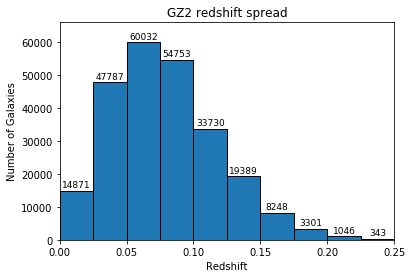

In [2]:
# Bin all galaxies into redshift bins of size 0.025 between 0 and 0.25
all_binned, bin_edges = np.histogram(gz2_data["REDSHIFT"], bins=np.arange(0, 0.275, 0.025))
bin_centres = np.arange(0.0125, 0.2625, 0.025)

# Create a plot of number of gaalxies against redshift
plt.bar(bin_centres, all_binned, width=bin_edges[1]-bin_edges[0], edgecolor="black")
# plt.plot(bin_centres, all_binned) # Line plot
plt.xlim(0, max(bin_edges))
plt.ylim(0, max(all_binned)*1.1)
plt.xlabel("Redshift")
plt.ylabel("Number of Galaxies")
plt.title("GZ2 redshift spread")

# Add numbers ontop of bars, comment out if not needed
for i in range(len(bin_centres)):
    plt.text(bin_centres[i], all_binned[i]+max(all_binned)/60, str(int(all_binned[i])), fontsize=9, ha='center')

#Show plot
plt.show()

The plot has a peak in the $0.05 < z < 0.075$ bin, and most galaxies are within the range $0 \leq z < 0.15$.

Now we want to plot how the merger fraction of galaxies, $f_m$, changes with redshift. To do so, we must choose a threshold of what is classified as a merger.

The GZ2 database has flagged some galaxies as definitely being mergers, denoted by the column "t08_odd_feature_a24_merger_flag" == 1, of which there are 513 in the database. This is a hard threshold to pass, hence the low number of galaxies that have this flag. We will later choose our own threshold, letting more galaxies count as mergers, but this will also increase the rate of false positives if we choose our threshold too low.

First we will plot a graph of merger fraction, $f_m$, against redshift for the 513 galaxies that are flagged as mergers in the GZ2 database.

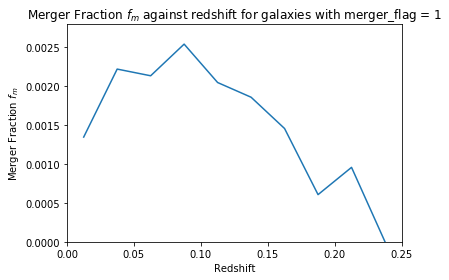

In [3]:
# Bin all galaxies into redshift bins of size 0.025 between 0 and 0.25
all_binned, bin_edges = np.histogram(gz2_data["REDSHIFT"], bins=np.arange(0, 0.275, 0.025))
bin_centres = np.arange(0.0125, 0.2625, 0.025)

# Bin galaxies with merger_flag = 1 into redshift bins
mergers = gz2_data[gz2_data["t08_odd_feature_a24_merger_flag"] == 1]
mergers_binned, bin_edges = np.histogram(mergers["REDSHIFT"], bins=np.arange(0, 0.275, 0.025))

merger_fraction_redshift = mergers_binned / all_binned

plt.plot(bin_centres, merger_fraction_redshift)
plt.xlim(0, max(bin_edges))
plt.ylim(0, max(merger_fraction_redshift)*1.1)
plt.xlabel("Redshift")
plt.ylabel("Merger Fraction $f_m$")
plt.title("Merger Fraction $f_m$ against redshift for galaxies with merger_flag = 1")
plt.show()

The low number of galaxies classified as galaxies here means that the merger fraction $f_m$ is at most $\approx 0.25\%$ for $0.75<z<0.1$. There is a general downward trend as $z$ increases, probably due to higher redshift galaxies appearing smaller and less bright, meaning they are harder for the GZ2 users to unanimously classify them as mergers.
<br>
If classification problems were not an issue, we would expect the number of galaxies that are merging to increase with redshift, as at earlier times the Universe was smaller and galaxy separations were smaller.

To increase the number of mergers in our sample, we will create our own criteria for classification. The most important parameters to consider are the "t06_odd_a14_yes_count" (number of votes for the galaxy having an odd feature), "t06_odd_a14_yes_debiased" (debiased vote fraction for the galaxy having an odd feature), "t08_odd_feature_a24_merger_count" (number of votes for the galaxy being a merger), "t08_odd_feature_a24_merger_debiased" (debiased vote fraction for the galaxy being a merger) columns in the GZ2 database.
<br>
As every user must answer the "anything odd?" question, the number of "odd yes" votes, and the debiased "odd yes" vote fraction likely give similar thresholds if the galaxy has been classified enough times.

We choose our first set of new criteria "Threshold 1":
- "t06_odd_a14_yes_count" $\geq$ 10
- "t06_odd_a14_yes_debiased" > 0.5
- "t08_odd_feature_a24_merger_debiased" > 0.5

This gives us a sample where the majority of GZ2 users thought that the galaxy was "odd", and at least half of these also thought it was a merger, with the condition that at least 10 people must have classified the galaxy as "odd".

Number of mergers: 5759


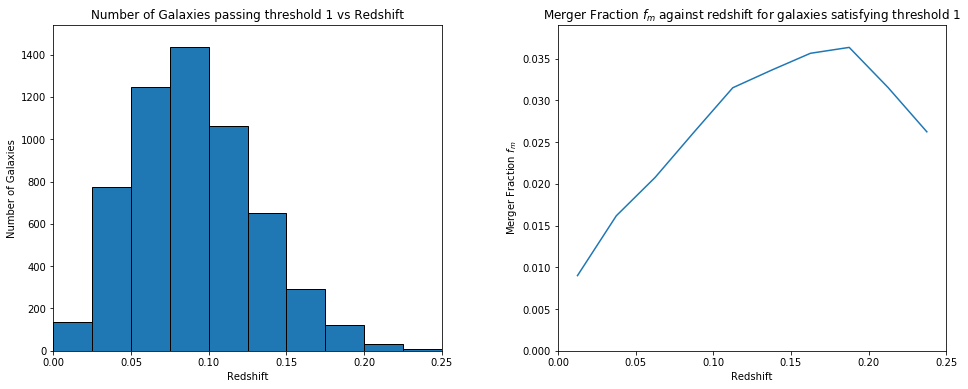

In [4]:
# Bin all galaxies into redshift bins of size 0.025 between 0 and 0.25
all_binned, bin_edges = np.histogram(gz2_data["REDSHIFT"], bins=np.arange(0, 0.275, 0.025))
bin_centres = np.arange(0.0125, 0.2625, 0.025)

# Bin galaxies passing the threshold 1 criteria into redshift bins
mergers_threshold_1 = gz2_data[gz2_data["t06_odd_a14_yes_debiased"] > 0.5]
mergers_threshold_1 = mergers_threshold_1[mergers_threshold_1["t06_odd_a14_yes_count"] >= 10]
mergers_threshold_1 = mergers_threshold_1[mergers_threshold_1["t08_odd_feature_a24_merger_debiased"] > 0.5]
mergers_threshold_1_binned, bin_edges = np.histogram(mergers_threshold_1["REDSHIFT"], bins=np.arange(0, 0.275, 0.025))
print("Number of mergers: " +str(sum(mergers_threshold_1_binned)))

merger_fraction_threshold_1 = mergers_threshold_1_binned / all_binned

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of the number of galaxies passing the threshold 1 criteria
ax[0].bar(bin_centres, mergers_threshold_1_binned, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax[0].set_xlim(0, max(bin_edges))
ax[0].set_ylim(0, max(mergers_threshold_1_binned)*1.075)
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Number of Galaxies")
ax[0].set_title("Number of Galaxies passing threshold 1 vs Redshift")

# Plot histogram of the merger fraction against redshift, classifying threshold 1 galaxies as mergers
ax[1].plot(bin_centres, merger_fraction_threshold_1)
ax[1].set_xlim(0, max(bin_edges))
ax[1].set_ylim(0, max(merger_fraction_threshold_1)*1.075)
ax[1].set_xlabel("Redshift")
ax[1].set_ylabel("Merger Fraction $f_m$")
ax[1].set_title("Merger Fraction $f_m$ against redshift for galaxies satisfying threshold 1")

fig.subplots_adjust(wspace=0.3)

The spread of galaxies passing this criteria is similar to the spread of the entire GZ2 data set, but it is shifted towards higher redshift. This results in a general upward trend of merger fraction $f_m$ with redshift $z$, as we expected earlier.
<br>
Beyond $z=0.2$, there is a dip in the merger fraction. This could be due to higher redshift galaxies being dimmer (as they are further away), and therefore harder to classify, or it could be due to the fact that the number of galaxies in the GZ2 data set with $z>0.2$ is small, giving a higher statistical error in the merger fraction due to a smaller sample size.

We now plot the same graphs as above, but with different thresholds on the merger classification. We use the thresholds described in [Willett et al. (2013)](https://arxiv.org/abs/1308.3496v2) on the "anything odd?" task, and a cut off of 0.4 on the debiased merger vote fraction and at least 10 merger votes to select mergers. We also use redshift bins of size 0.01.
<br>
"Threshold 2":
- "t06_odd_a14_yes_count" $\geq$ 20
- "t06_odd_a14_yes_debiased" > 0.42
- "t08_odd_feature_a24_merger_count" $\geq$ 10
- "t08_odd_feature_a24_merger_debiased" > 0.4


Number of mergers: 7236


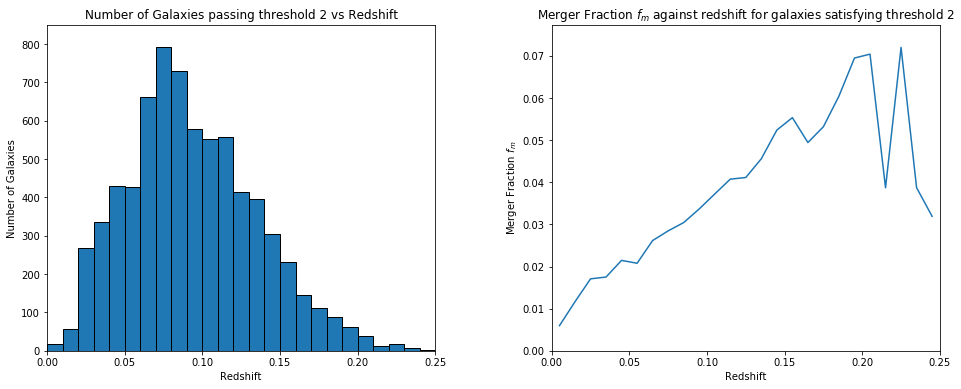

In [5]:
# Bin all galaxies into redshift bins of size 0.025 between 0 and 0.25
all_binned, bin_edges = np.histogram(gz2_data["REDSHIFT"], bins=np.arange(0, 0.26, 0.01))
bin_centres = np.arange(0.005, 0.255, 0.01)

# Bin galaxies passing the threshold 2 criteria into redshift bins
mergers_threshold_2 = gz2_data[gz2_data["t06_odd_a14_yes_count"] >= 20]
mergers_threshold_2 = mergers_threshold_2[mergers_threshold_2["t06_odd_a14_yes_debiased"] > 0.42]
mergers_threshold_2 = mergers_threshold_2[mergers_threshold_2["t08_odd_feature_a24_merger_count"] >= 10]
mergers_threshold_2 = mergers_threshold_2[mergers_threshold_2["t08_odd_feature_a24_merger_debiased"] > 0.4]
mergers_threshold_2_binned, bin_edges = np.histogram(mergers_threshold_2["REDSHIFT"], bins=np.arange(0, 0.26, 0.01))
print("Number of mergers: " +str(sum(mergers_threshold_2_binned)))

merger_fraction_threshold_2 = mergers_threshold_2_binned / all_binned

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of the number of galaxies passing the threshold 2 criteria
ax[0].bar(bin_centres, mergers_threshold_2_binned, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax[0].set_xlim(0, max(bin_edges))
ax[0].set_ylim(0, max(mergers_threshold_2_binned)*1.075)
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Number of Galaxies")
ax[0].set_title("Number of Galaxies passing threshold 2 vs Redshift")

# Plot histogram of the merger fraction against redshift, classifying threshold 2 galaxies as mergers
ax[1].plot(bin_centres, merger_fraction_threshold_2)
ax[1].set_xlim(0, max(bin_edges))
ax[1].set_ylim(0, max(merger_fraction_threshold_2)*1.075)
ax[1].set_xlabel("Redshift")
ax[1].set_ylabel("Merger Fraction $f_m$")
ax[1].set_title("Merger Fraction $f_m$ against redshift for galaxies satisfying threshold 2")

fig.subplots_adjust(wspace=0.3)

Here we can see that overall the merger fraction $f_m$ increases, up to a peak of around $7\%$, double that of the previous sample used. However beyond $z=0.2$, there is a wild change in the merger fraction, due to the low sample size of galaxies at these reshifts. It is likely sensible to restrict ourselves to redshifts of $z<0.2$ in order to avoid this problem.

For comparison, we plot the number of "odd" galaxies, using the same criteria as "threshold 2" above.

Number of odd galaxies: 22409


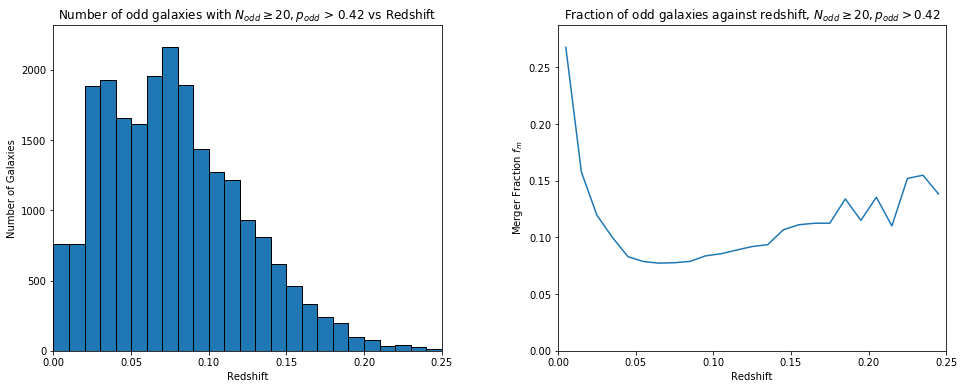

In [6]:
# Bin all galaxies into redshift bins of size 0.025 between 0 and 0.25
all_binned, bin_edges = np.histogram(gz2_data["REDSHIFT"], bins=np.arange(0, 0.26, 0.01))
bin_centres = np.arange(0.005, 0.255, 0.01)

# Bin odd galaxies passing the threshold 2 criteria into redshift bins
odd_yes = gz2_data[gz2_data["t06_odd_a14_yes_count"] >= 20]
odd_yes = odd_yes[odd_yes["t06_odd_a14_yes_debiased"] > 0.5]
odd_yes_binned, bin_edges = np.histogram(odd_yes["REDSHIFT"], bins=np.arange(0, 0.26, 0.01))
print("Number of odd galaxies: " + str(sum(odd_yes_binned)))

odd_fraction = odd_yes_binned / all_binned

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of the number of odd galaxies passing the threshold 2 criteria
ax[0].bar(bin_centres, odd_yes_binned, width=bin_edges[1]-bin_edges[0], edgecolor="black")
ax[0].set_xlim(0, max(bin_edges))
ax[0].set_ylim(0, max(odd_yes_binned)*1.075)
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Number of Galaxies")
ax[0].set_title("Number of odd galaxies with $N_{odd} \geq 20, p_{odd}$ > 0.42 vs Redshift")

# Plot histogram of the odd fraction against redshift
ax[1].plot(bin_centres, odd_fraction)
ax[1].set_xlim(0, max(bin_edges))
ax[1].set_ylim(0, max(odd_fraction)*1.075)
ax[1].set_xlabel("Redshift")
ax[1].set_ylabel("Merger Fraction $f_m$")
ax[1].set_title("Fraction of odd galaxies against redshift, $N_{odd} \geq 20, p_{odd} > 0.42$")

fig.subplots_adjust(wspace=0.3)

At low redshifts the fraction of odd galaxies is very high, which then drops rapidly before slowly rising again for $z>0.05$. We see the same noisy data for high redshifts beyond $\sim z>0.17$. This is again due to the small sample size at higher redshifts.

# Magnitudes
First we will create scatter plots of magnitude against the merger vote fraction $p_m$ and redshift, to get an idea of how the magnitude changes with these variables.

There are 5 different Petrosian magnitudes we can use: u band, g band, r band, i band and z band. The wavelengths of the filters the SDSS uses can be found [here](https://classic.sdss.org/dr7/). For this first plot we will use the r band apparent magnitudes, $m_r$, where the r band filter has an average wavelength of $\lambda =	616.5 \ \text{nm}$.

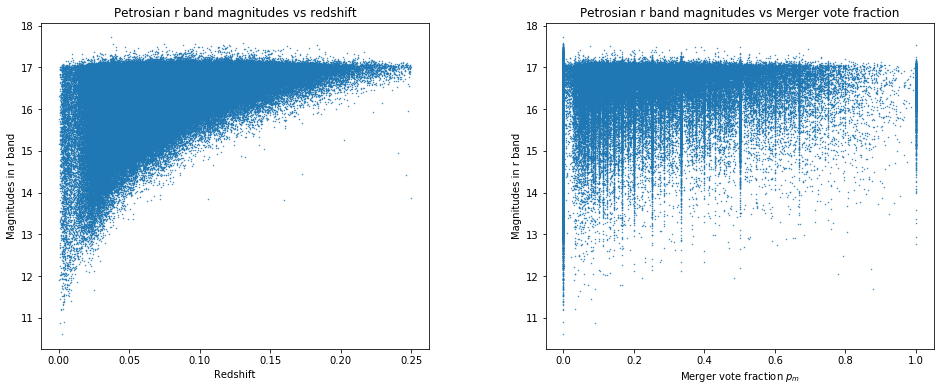

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot r band magnitudes against redshift
ax[0].scatter(gz2_data["REDSHIFT"], gz2_data["PETROMAG_R"], s=0.2)
ax[0].set_xlabel("Redshift")
ax[0].set_ylabel("Magnitudes in r band")
ax[0].set_title("Petrosian r band magnitudes vs redshift")

# Plot r band magnitudes against merger vote fraction
ax[1].scatter(gz2_data["t08_odd_feature_a24_merger_debiased"], gz2_data["PETROMAG_R"], s=0.2)
ax[1].set_xlabel("Merger vote fraction $p_m$")
ax[1].set_ylabel("Magnitudes in r band")
ax[1].set_title("Petrosian r band magnitudes vs Merger vote fraction")

fig.subplots_adjust(wspace=0.3)

There is a spread in the r band magnitudes from $m_r \sim 11$ to $m_r \sim 17.7$ which is the limit of SDSS. There is a general logarithmic increase in the minimum apparent magnitude as redshift increases, as we would expect from the relation between flux, magnitude and luminosity distance.

The plot of $m_r$ against the merger vote fraction has interesting "spike-like" features at many values, most notably at 1, 0.5, 0.33, 0.66, 0.25, 0.2, all fractions with small numerators and denominators. The prevalence of galaxies at these spikes is most likely due to a low number of people classifying the galaxy as odd, and therefore only 1 user, or 1 out of two, or 1 out of 3 etc. classify it as a merger. Once we filter out galaxies which pass our merger classification threshold, we should expect these peaks to almost disappear, as the likelihood of having a fraction which can be reduced to these low numbers is reduced.

Now we plot the same graphs, but this time using only galaxies which pass our previous criteria "threshold 2".
<br>
Note that because one criterion is that the debiased merger vote fraction $p_m$ must be $>0.4$, the scale on the second plot of magnitude vs merger vote fraction will change.

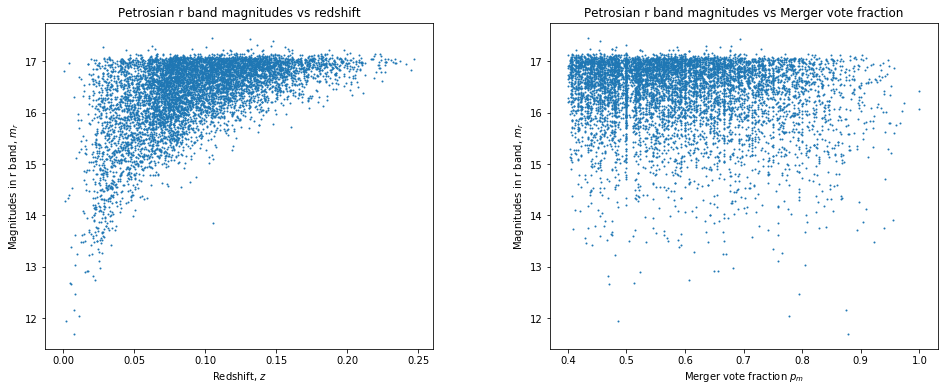

In [8]:
# Create table of galaxies classified as mergers previously
mergers_magnitudes = mergers_threshold_2.copy()

fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot r band magnitudes of mergers against redshift
ax[0].scatter(mergers_magnitudes["REDSHIFT"], mergers_magnitudes["PETROMAG_R"], s=1)
# ax[0].set_xlim(0, 0.25)
ax[0].set_xlabel("Redshift, $z$")
ax[0].set_ylabel("Magnitudes in r band, $m_r$")
ax[0].set_title("Petrosian r band magnitudes vs redshift")

# Plot r band magnitudes of mergers against merger vote fraction
ax[1].scatter(mergers_magnitudes["t08_odd_feature_a24_merger_debiased"], mergers_magnitudes["PETROMAG_R"], s=1)
# ax[1].set_xlim(0, 1.05)
ax[1].set_xlabel("Merger vote fraction $p_m$")
ax[1].set_ylabel("Magnitudes in r band, $m_r$")
ax[1].set_title("Petrosian r band magnitudes vs Merger vote fraction")

fig.subplots_adjust(wspace=0.3)

We see the same overall trend as before, but the number of galaxies at each redshift follows the spread of mergers we found earlier. At low redshifts the number of mergers was low, and as a result we no longer see as many points near $z=0$. The spike-like features have also been reduced, but are still faintly present.

For interest, we plot magnitudes against redshift for the other 4 bands of the SDSS. These can be seen below.

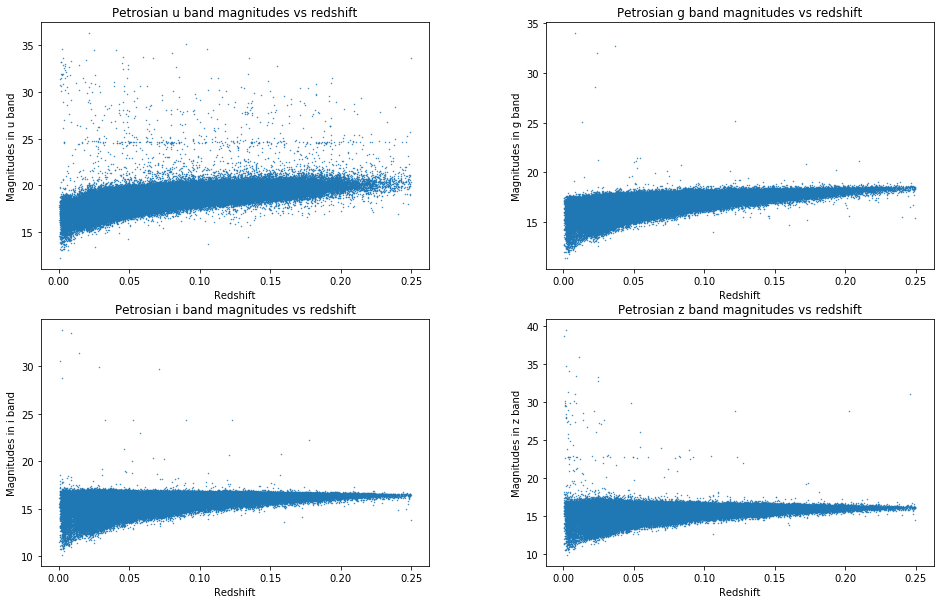

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))

# Plot r band magnitudes of mergers against redshift
ax[0, 0].scatter(gz2_data["REDSHIFT"], gz2_data["PETROMAG_U"], s=0.2)
ax[0, 0].set_xlabel("Redshift")
ax[0, 0].set_ylabel("Magnitudes in u band")
ax[0, 0].set_title("Petrosian u band magnitudes vs redshift")

# Plot r band magnitudes of mergers against merger vote fraction
ax[0, 1].scatter(gz2_data["REDSHIFT"], gz2_data["PETROMAG_G"], s=0.2)
ax[0, 1].set_xlabel("Redshift")
ax[0, 1].set_ylabel("Magnitudes in g band")
ax[0, 1].set_title("Petrosian g band magnitudes vs redshift")

# Plot r band magnitudes of mergers against redshift
ax[1, 0].scatter(gz2_data["REDSHIFT"], gz2_data["PETROMAG_I"], s=0.2)
ax[1, 0].set_xlabel("Redshift")
ax[1, 0].set_ylabel("Magnitudes in i band")
ax[1, 0].set_title("Petrosian i band magnitudes vs redshift")

# Plot r band magnitudes of mergers against merger vote fraction
ax[1, 1].scatter(gz2_data["REDSHIFT"], gz2_data["PETROMAG_Z"], s=0.2)
ax[1, 1].set_xlabel("Redshift")
ax[1, 1].set_ylabel("Magnitudes in z band")
ax[1, 1].set_title("Petrosian z band magnitudes vs redshift")

fig.subplots_adjust(wspace=0.3)

These plots of the other magnitude band show a similar distribution of galaxies as that of the r band magnitudes, however there are also some very low brightness galaxies. Some of these are likely erroneous data points, as the limit of the SDSS is $m\sim 22$, so we should not expect to see any data points at magnitudes well above 30 or even 40, many orders of magnitude dimmer. For the rest of our analysis we will use the r band magnitudes, $m_r$.

In order to see whether the magnitude of the galaxy affects the likelihood of it being classified as a merger, we will plot the merger fraction $f_m$ against redshift again but with galaxies put into magnitude bins. Our hypothesis is that brighter galaxies are more likely to be classified as mergers, as it is easier to spot the faint features of mergers if there is more light.

We bin galaxies by magnitudes as follows:
- $m_r \leq 15.5$
- $15.5 < m_r \leq 16$
- $16 < m_r \leq 16.5$
- $16.5 < m_r \leq 17$
- $m_r > 17$

We plot histograms of magnitudes for the entire GZ2 data set, and also for the galaxies we have classified as mergers previously.

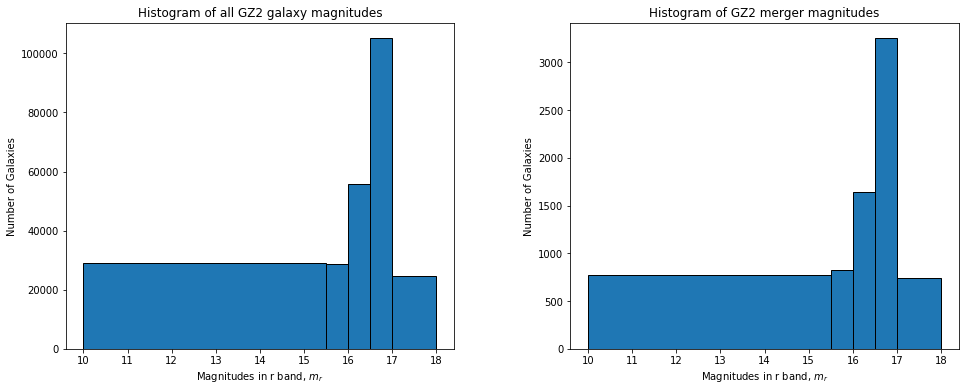

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Plot histogram of the all GZ2 galaxy magnitudes
ax[0].hist(gz2_data["PETROMAG_R"], bins=[10, 15.5, 16, 16.5, 17, 18], edgecolor="black")
ax[0].set_xlabel("Magnitudes in r band, $m_r$")
ax[0].set_ylabel("Number of Galaxies")
ax[0].set_title("Histogram of all GZ2 galaxy magnitudes")

# Plot histogram of the GZ2 galaxy magnitudes, which are classified as mergers
ax[1].hist(mergers_magnitudes["PETROMAG_R"], bins=[10, 15.5, 16, 16.5, 17, 18], edgecolor="black")
ax[1].set_xlabel("Magnitudes in r band, $m_r$")
ax[1].set_ylabel("Number of Galaxies")
ax[1].set_title("Histogram of GZ2 merger magnitudes")

fig.subplots_adjust(wspace=0.3)

plt.show()

Now that we have seen hpw our binned data is spread, we want to perform the same analysis of merger fraction $f_m$ as before, but for each magnitude range individually. We plot these on the same graph to compare.

Note that as we have seen previously, for higher redshifts there is a trend towards more positive magnitudes, so, for example, our magnitude bin for $m_r \leq 15.5$ has very few galaxies beyond $z=0.1$. We therefore restrict our comparison to only galaxies with $z<0.1$ here.

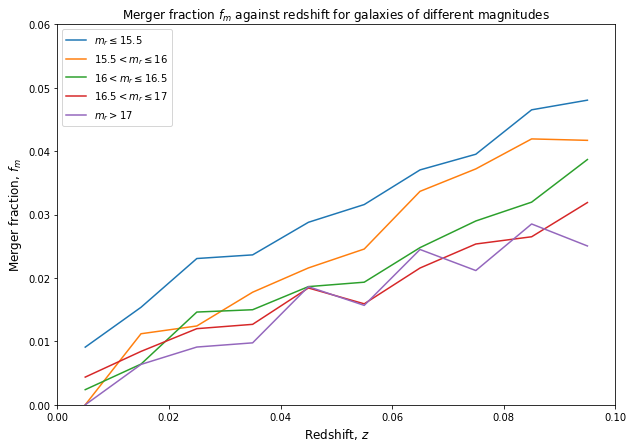

In [11]:
# Bin data into our defined magnitude bins
mag_less_than_155 = gz2_data[gz2_data["PETROMAG_R"] < 15.5]
mag_155_to_16 = gz2_data[(gz2_data["PETROMAG_R"] >= 15.5) & (gz2_data["PETROMAG_R"] < 16)]
mag_16_to_165 = gz2_data[(gz2_data["PETROMAG_R"] >= 16) & (gz2_data["PETROMAG_R"] < 16.5)]
mag_165_to_17 = gz2_data[(gz2_data["PETROMAG_R"] >= 16.5) & (gz2_data["PETROMAG_R"] < 17)]
mag_greater_than_17 = gz2_data[gz2_data["PETROMAG_R"] >= 17]


# Define a function that given some data, will return the merger fraction against redshift
def merger_fraction_binning(mag_data, max_z=0.25, z_steps=0.01):
    """Takes data, classifies the mergers within this data according to preset thresholds, returns an array 
    of merger fraction against redshift and the centres of each redshift bin for plotting"""
    
    # Pick out mergers from input data, up to the maximum redshift specified
    mag_data_mergers = mag_data[mag_data["REDSHIFT"] <= max_z]
    mag_data_mergers = mag_data_mergers[mag_data_mergers["t06_odd_a14_yes_count"] >= 20]
    mag_data_mergers = mag_data_mergers[mag_data_mergers["t06_odd_a14_yes_debiased"] > 0.42]
    mag_data_mergers = mag_data_mergers[mag_data_mergers["t08_odd_feature_a24_merger_count"] >= 10]
    mag_data_mergers = mag_data_mergers[mag_data_mergers["t08_odd_feature_a24_merger_debiased"] > 0.4]
    
    # Bin data by redshift, with the bin sizes specified from 0 to the maximum
    allbinned, mag_bin_edges = np.histogram(mag_data["REDSHIFT"], bins=np.arange(0, max_z+z_steps, z_steps))
    mergersbinned, mag_bin_edges = np.histogram(mag_data_mergers["REDSHIFT"], bins=np.arange(0, max_z+z_steps, z_steps))
    
    # Calculate the centre of the bins for plotting data
    mag_bin_centres = mag_bin_edges[:-1] + z_steps/2
    
    allbinned = allbinned.astype(float)
    mergersbinned = mergersbinned.astype(float)
    
    # If there are no galaxies in redshift bin, make dividing by zero give zero to avoid error
    mag_merger_fraction = np.divide(mergersbinned, allbinned, out=np.zeros_like(mergersbinned), where=allbinned!=0)
    
    # mag_merger_fraction[mag_merger_fraction == 0 ] = np.nan
    
    return mag_merger_fraction, mag_bin_centres


# Set maximum redshift and size of redshift bins
max_redshift = 0.10
redshift_steps = 0.01

# Pass data through merger_fraction_binning() to create merger fraction data for that magnitude
mag_less_than_155_merger_fraction, bins_155 = merger_fraction_binning(mag_less_than_155, max_z=max_redshift, z_steps=redshift_steps)
mag_155_to_16_merger_fraction, bins_155_to_16 = merger_fraction_binning(mag_155_to_16, max_z=max_redshift, z_steps=redshift_steps)
mag_16_to_165_merger_fraction, bins_16_to_165 = merger_fraction_binning(mag_16_to_165, max_z=max_redshift, z_steps=redshift_steps)
mag_165_to_17_merger_fraction, bins_165_to_17 = merger_fraction_binning(mag_165_to_17, max_z=max_redshift, z_steps=redshift_steps)
mag_greater_than_17_merger_fraction, bins_17 = merger_fraction_binning(mag_greater_than_17, max_z=max_redshift, z_steps=redshift_steps)

# Plot all data on one graph
plt.figure(figsize=(10,7))
plt.plot(bins_155, mag_less_than_155_merger_fraction, label="$m_r \leq 15.5$")
plt.plot(bins_155_to_16, mag_155_to_16_merger_fraction, label="$15.5 < m_r \leq 16$")
plt.plot(bins_16_to_165, mag_16_to_165_merger_fraction, label="$16 < m_r \leq 16.5$")
plt.plot(bins_165_to_17, mag_165_to_17_merger_fraction, label="$16.5 < m_r \leq 17$")
plt.plot(bins_17, mag_greater_than_17_merger_fraction, label="$m_r > 17$")

plt.xlabel("Redshift, $z$", fontsize=12)
plt.ylabel("Merger fraction, $f_m$", fontsize=12)
plt.xlim(0,0.1)
plt.ylim(0,0.06)
plt.title("Merger fraction $f_m$ against redshift for galaxies of different magnitudes", fontsize=12)
plt.legend()
plt.show()

We can see from this graph that our hypothesis does indeed seem to be correct, galaxies with greater apparent brightnesses (less positive apparent magntiudes) have a higher merger fraction than dimmer galaxies at almost all redshifts. Therefore we can conclude that galaxies classified as mergers are on average brighter. This could be due to mergers physically being brighter due to starbursts that occur, or that brighter galaxies make fainter features easier to see, so mergers are easier to classify.